# Predicting Heart Disease

**Playground Series - Season 6 Episode 2**

https://www.kaggle.com/competitions/playground-series-s6e2

By Mike Johnson
****

## 1.0 Set Up

### 1.1 Import Libraries

In [24]:
# Data manipulation
import pandas as pd
import numpy as np

# Stats
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Gradient boosting
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Metrics (ROC AUC is your competition metric)
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# Hyperparameter tuning
import optuna

### 1.2 Load Data

In [2]:
# Load data
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

print(f"Training Set Shape: {train.shape}")
print(f"Test Set Shape: {test.shape}")

Training Set Shape: (630000, 14)
Test Set Shape: (270000, 13)


In [3]:
# View training data structure
train.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


### 1.3 Encode Heart Disease

In [4]:
# Encode Heart Disease
train['Heart Disease'] = np.where(train['Heart Disease'] == 'Presence', 1, 0)

train.head()


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


### 1.4 Train-Dev Split

In [5]:
# Separate features from target variable
X = train.drop('Heart Disease', axis = 1)
y = train['Heart Disease']

# Create train-dev split
X_train, X_dev, y_train, y_dev = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for dev set
    stratify=y,         # Maintains class distribution
    random_state=206    # For reproducibility
)

# Check the splits
print(f"Training set: {X_train.shape}")
print(f"Dev set: {X_dev.shape}")
print(f"\nClass distribution in train: {y_train.value_counts(normalize=True)}")
print(f"Class distribution in dev: {y_dev.value_counts(normalize=True)}")

Training set: (504000, 13)
Dev set: (126000, 13)

Class distribution in train: Heart Disease
0    0.551661
1    0.448339
Name: proportion, dtype: float64
Class distribution in dev: Heart Disease
0    0.551659
1    0.448341
Name: proportion, dtype: float64


In [9]:
# Merge X_train and y_train for eda and preprocessing.
df_train = pd.concat([X_train, y_train], axis = 1)

## 2.0 Exploratory Data Analysis

### 2.1 Data Quality & Basic Stats

Findings:
* No missing values
* All features properly encoded

In [12]:
# Check for missing values
print("Missing values:")
print(df_train.isnull().sum())

Missing values:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64


In [14]:
# Data types
print("\nData types:")
print(df_train.dtypes)


Data types:
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                int64
dtype: object


In [18]:
# Basic Stats
df_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Age,504000.0,54.14,8.26,29.0,48.0,54.0,60.0,77.0
Sex,504000.0,0.71,0.45,0.0,0.0,1.0,1.0,1.0
Chest pain type,504000.0,3.31,0.85,1.0,3.0,4.0,4.0,4.0
BP,504000.0,130.49,14.98,94.0,120.0,130.0,140.0,200.0
Cholesterol,504000.0,244.99,33.71,126.0,222.0,243.0,269.0,564.0
FBS over 120,504000.0,0.08,0.27,0.0,0.0,0.0,0.0,1.0
EKG results,504000.0,0.98,1.00,0.0,0.0,0.0,2.0,2.0
Max HR,504000.0,152.82,19.11,71.0,142.0,157.0,166.0,202.0
Exercise angina,504000.0,0.27,0.45,0.0,0.0,0.0,1.0,1.0
ST depression,504000.0,0.72,0.95,0.0,0.0,0.1,1.4,6.2


### 2.2 Target Variable Analysis

Findings: Slight imbalance. Consider downsampling.

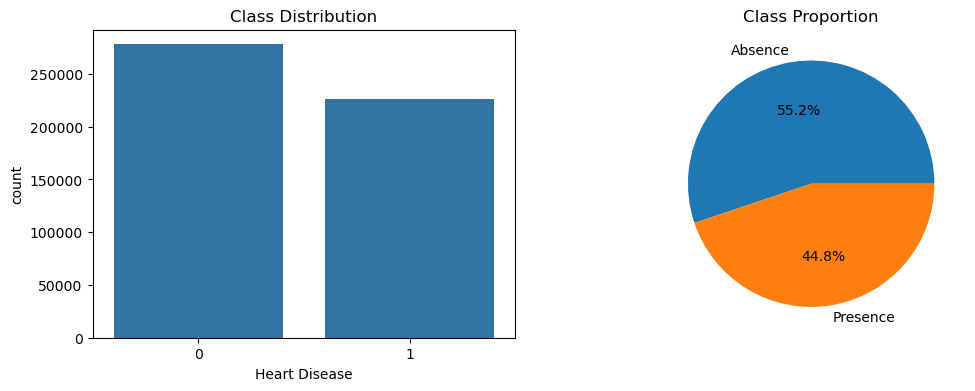

Heart Disease
0    278037
1    225963
Name: count, dtype: int64


In [19]:
# Class balance
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(data=df_train, x='Heart Disease', ax=ax[0])
ax[0].set_title('Class Distribution')

# Percentage
class_dist = df_train['Heart Disease'].value_counts(normalize=True)
ax[1].pie(class_dist, labels=['Absence', 'Presence'], autopct='%1.1f%%')
ax[1].set_title('Class Proportion')
plt.show()

print(df_train['Heart Disease'].value_counts())

### 2.3 Feature Distributions by Target Class

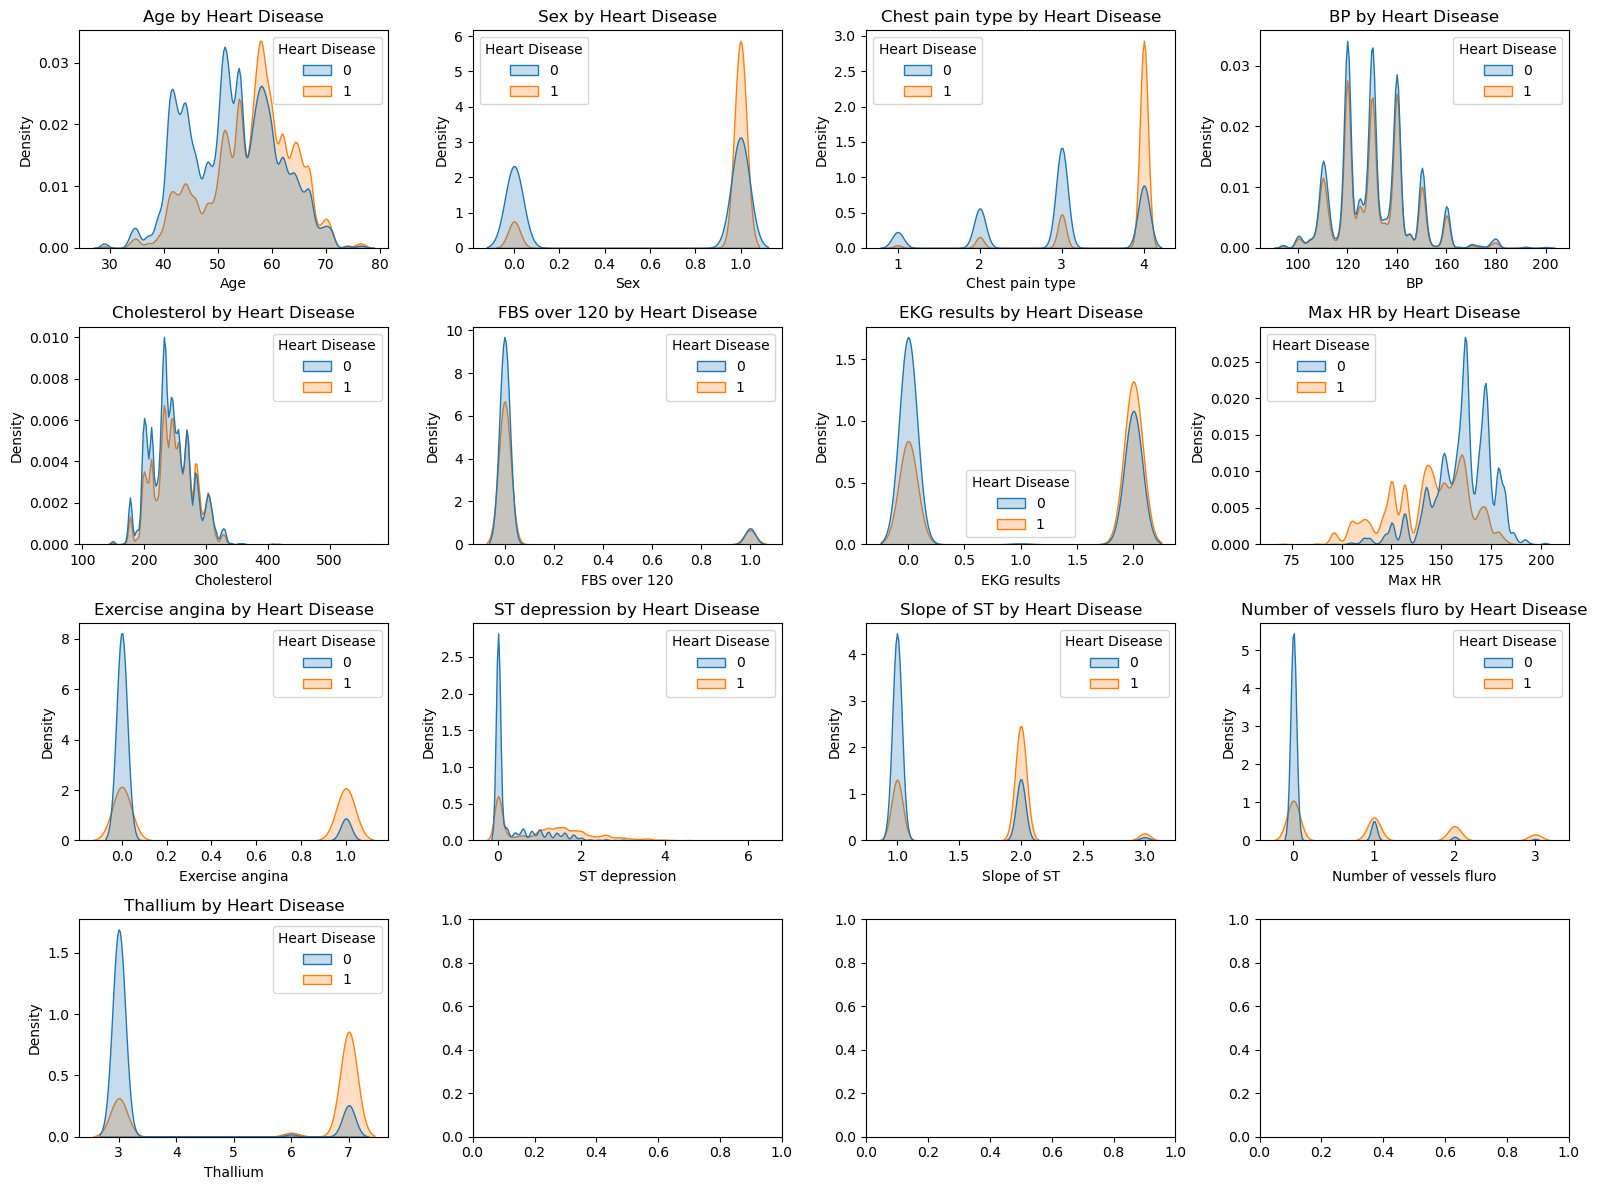

In [20]:
# Identify numeric columns
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.drop('Heart Disease')

# Create distribution plots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        sns.kdeplot(data=df_train, x=col, hue='Heart Disease', ax=axes[idx], fill=True)
        axes[idx].set_title(f'{col} by Heart Disease')
        
plt.tight_layout()
plt.show()

### 2.4 Correlation Analysis

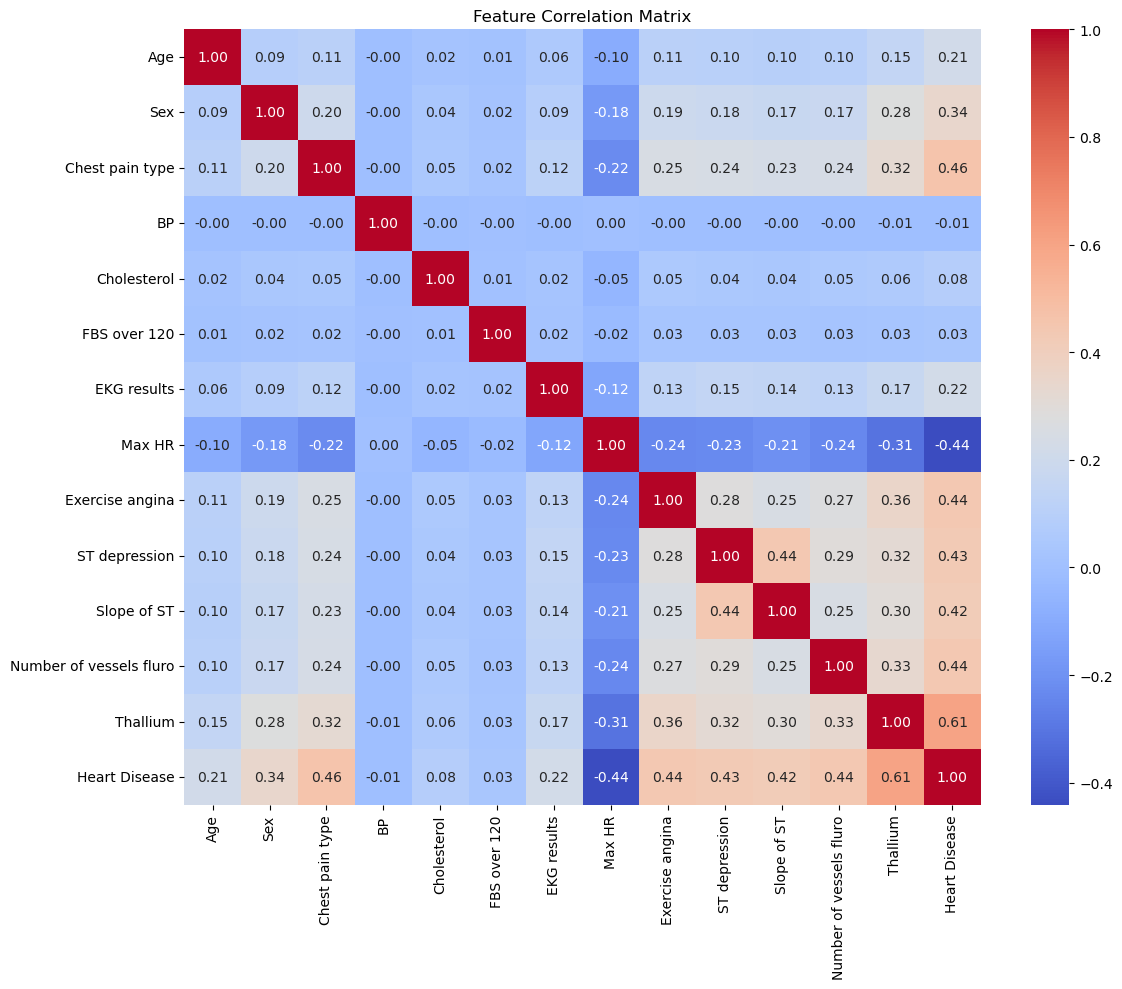

In [10]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### 2.5 Outlier Detection

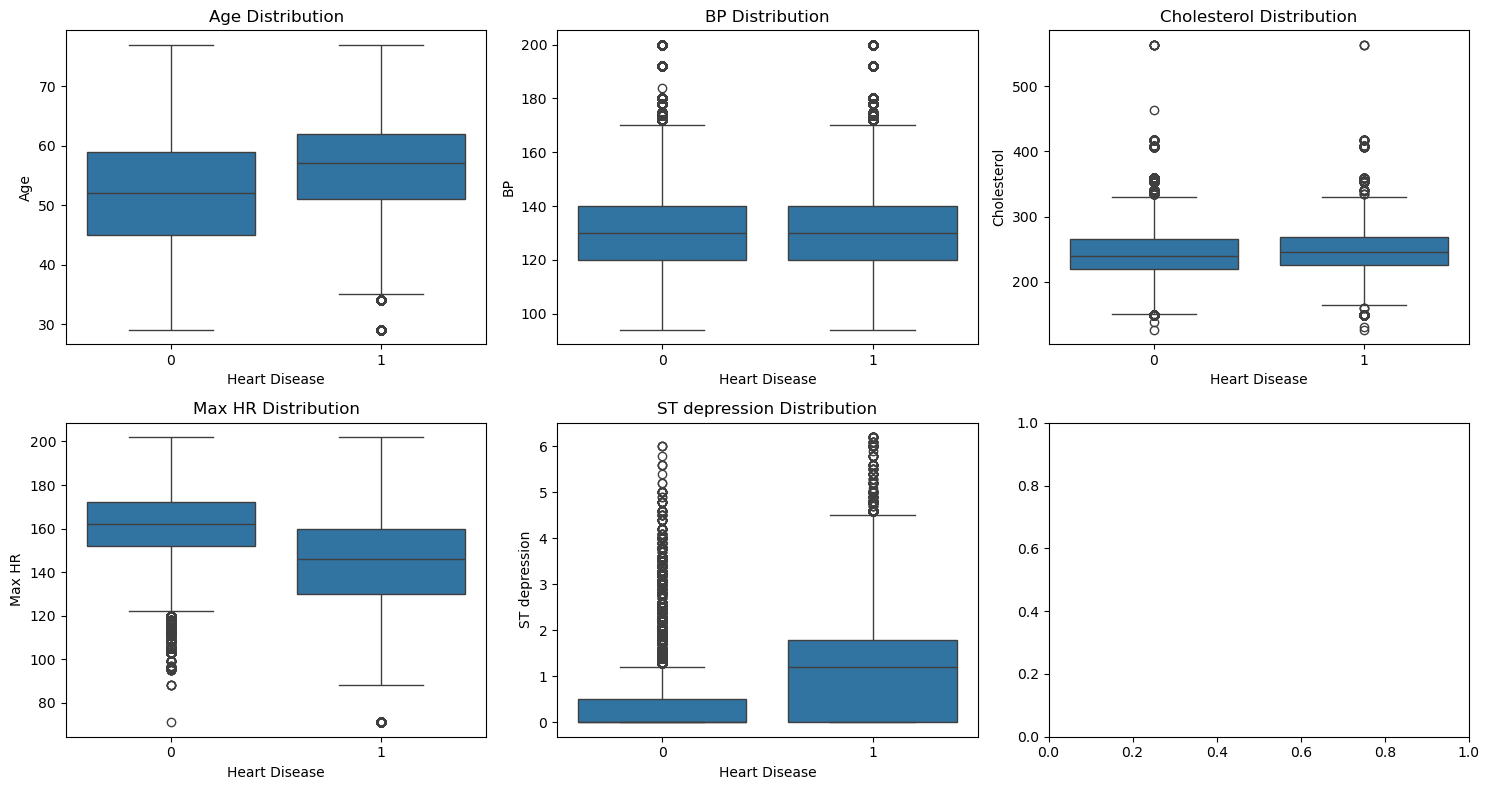

Age: 0 extreme outliers (0.00%)
BP: 0 extreme outliers (0.00%)
Cholesterol: 120 extreme outliers (0.02%)
Max HR: 0 extreme outliers (0.00%)
ST depression: 112 extreme outliers (0.02%)


In [23]:
# Box plots for continuous features
continuous_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(continuous_features):
    sns.boxplot(data=df_train, y=col, x='Heart Disease', ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution')
    
plt.tight_layout()
plt.show()

# Check for extreme outliers
for col in continuous_features:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_train[col] < (Q1 - 3 * IQR)) | (df_train[col] > (Q3 + 3 * IQR))).sum()
    print(f"{col}: {outliers} extreme outliers ({outliers/len(df_train)*100:.2f}%)")


### 2.6 Statistical Tests

In [25]:
# Define feature groups
continuous_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
categorical_features = ['Sex', 'Chest pain type', 'FBS over 120', 
                        'EKG results', 'Exercise angina', 'Slope of ST', 
                        'Number of vessels fluro', 'Thallium']

# For continuous features: t-test
print("T-tests for continuous features:")
print("=" * 60)
for col in continuous_features:
    presence = df_train[df_train['Heart Disease'] == 1][col]
    absence = df_train[df_train['Heart Disease'] == 0][col]
    t_stat, p_value = stats.ttest_ind(presence, absence)
    significance = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else ''))
    print(f"{col:25} p-value = {p_value:.4e} {significance}")

# For categorical features: chi-square test
print("\n\nChi-square tests for categorical features:")
print("=" * 60)
for feature in categorical_features:
    contingency = pd.crosstab(df_train[feature], df_train['Heart Disease'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    significance = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else ''))
    print(f"{feature:25} p-value = {p_value:.4e} {significance}")

print("\n*** = p < 0.001 (highly significant)")
print("**  = p < 0.01 (very significant)")
print("*   = p < 0.05 (significant)")

T-tests for continuous features:
Age                       p-value = 0.0000e+00 ***
BP                        p-value = 2.5540e-04 ***
Cholesterol               p-value = 0.0000e+00 ***
Max HR                    p-value = 0.0000e+00 ***
ST depression             p-value = 0.0000e+00 ***


Chi-square tests for categorical features:
Sex                       p-value = 0.0000e+00 ***
Chest pain type           p-value = 0.0000e+00 ***
FBS over 120              p-value = 5.0429e-119 ***
EKG results               p-value = 0.0000e+00 ***
Exercise angina           p-value = 0.0000e+00 ***
Slope of ST               p-value = 0.0000e+00 ***
Number of vessels fluro   p-value = 0.0000e+00 ***
Thallium                  p-value = 0.0000e+00 ***

*** = p < 0.001 (highly significant)
**  = p < 0.01 (very significant)
*   = p < 0.05 (significant)
